In [56]:
import pandas as pd
import numpy as np
%matplotlib inline 
%pylab inline
pd.set_option("display.max_columns", 200)
pylab.rcParams['figure.figsize'] = 10, 5
pd.options.mode.chained_assignment = None
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor

Populating the interactive namespace from numpy and matplotlib


In [57]:
dados = pd.read_csv("2004-2019.tsv", sep = '\t')

In [58]:
diesel = dados[dados['PRODUTO'] == 'ÓLEO DIESEL'].copy()

In [59]:
diesel.head()

,Unnamed: 0,DATA INICIAL,DATA FINAL,REGIÃO,ESTADO,PRODUTO,NÚMERO DE POSTOS PESQUISADOS,UNIDADE DE MEDIDA,PREÇO MÉDIO REVENDA,DESVIO PADRÃO REVENDA,PREÇO MÍNIMO REVENDA,PREÇO MÁXIMO REVENDA,MARGEM MÉDIA REVENDA,COEF DE VARIAÇÃO REVENDA,PREÇO MÉDIO DISTRIBUIÇÃO,DESVIO PADRÃO DISTRIBUIÇÃO,PREÇO MÍNIMO DISTRIBUIÇÃO,PREÇO MÁXIMO DISTRIBUIÇÃO,COEF DE VARIAÇÃO DISTRIBUIÇÃO,MÊS,ANO
43547,43547,2004-05-09,2004-05-15,CENTRO OESTE,DISTRITO FEDERAL,ÓLEO DIESEL,125,R$/l,1.447,0.031,1.350,1.490,0.198,0.021,1.249,0.012,1.2153,1.2817,0.01,5,2004
43548,43548,2004-05-09,2004-05-15,CENTRO OESTE,GOIAS,ÓLEO DIESEL,373,R$/l,1.437,0.059,1.300,1.660,0.157,0.041,1.28,0.024,1.2119,1.3801,0.019,5,2004
43549,43549,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO,ÓLEO DIESEL,190,R$/l,1.600,0.061,1.460,1.790,0.195,0.038,1.405,0.06,1.22,1.549,0.043,5,2004
43550,43550,2004-05-09,2004-05-15,CENTRO OESTE,MATO GROSSO DO SUL,ÓLEO DIESEL,157,R$/l,1.526,0.045,1.399,1.659,0.163,0.029,1.363,0.022,1.3055,1.4407,0.016,5,2004
43551,43551,2004-05-09,2004-05-15,NORDESTE,ALAGOAS,ÓLEO DIESEL,105,R$/l,1.362,0.025,1.310,1.450,0.146,0.018,1.216,0.02,1.1768,1.272,0.016,5,2004


# Validação

In [60]:
diesel['DATA INICIAL'] = pd.to_datetime(diesel['DATA INICIAL'])
diesel['DATA FINAL'] = pd.to_datetime(diesel['DATA FINAL'])

In [61]:
diesel_treino = diesel[diesel['DATA FINAL'] < "2011-01-01"]
diesel_valid = diesel[diesel['DATA FINAL'] >= "2011-01-01"]
diesel_treino.shape, diesel_valid.shape

((9233, 21), (11961, 21))

# Machine Learning

In [62]:
df_X_treino = pd.DataFrame(index=diesel_treino.index)
df_X_valid = pd.DataFrame(index=diesel_valid.index)

df_X_treino['ESTADO_'] = diesel_treino['ESTADO']
df_X_valid['ESTADO_'] = diesel_valid['ESTADO']

## Target

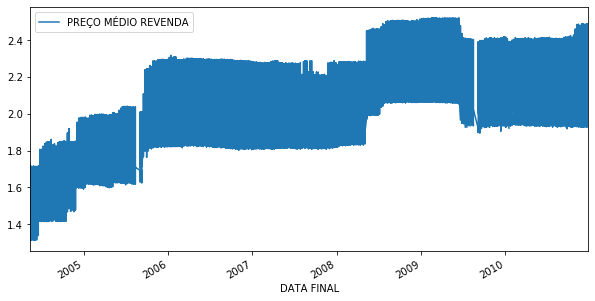

In [63]:
diesel_treino.plot(x='DATA FINAL', y='PREÇO MÉDIO REVENDA')

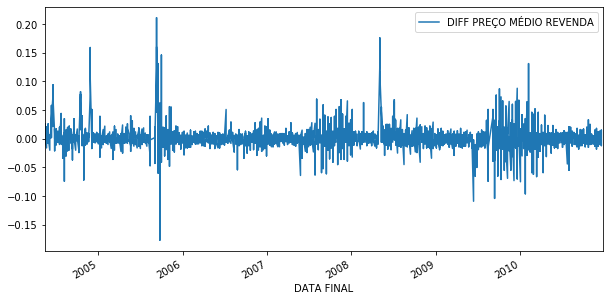

In [64]:
def target_diff(x):
    return x.diff().shift(-1)

diesel_treino['DIFF PREÇO MÉDIO REVENDA'] = diesel_treino.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].apply(target_diff)

diesel_treino.plot(x='DATA FINAL', y='DIFF PREÇO MÉDIO REVENDA')

In [65]:
df_X_treino['DIFF_PRECO_MEDIO_REVENDA_PROXIMA_SEMANA'] = diesel_treino.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].apply(target_diff)
df_X_valid['DIFF_PRECO_MEDIO_REVENDA_PROXIMA_SEMANA'] = diesel_valid.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].apply(target_diff)

### Sazonal

In [66]:
df_X_treino['MES'] = diesel_treino['DATA FINAL'].dt.month
df_X_treino['DIA'] = diesel_treino['DATA FINAL'].dt.day
#df_X_treino['DIA_DA_SEMANA'] = diesel_treino['DATA FINAL'].dt.weekday
df_X_treino['DIA_DO_ANO'] = diesel_treino['DATA FINAL'].dt.dayofyear
df_X_treino['SEMANA_DO_ANO'] = diesel_treino['DATA FINAL'].dt.weekofyear


df_X_valid['MES'] = diesel_valid['DATA FINAL'].dt.month
df_X_valid['DIA'] = diesel_valid['DATA FINAL'].dt.day
#df_X_valid['DIA_DA_SEMANA'] = diesel_valid['DATA FINAL'].dt.weekday
df_X_valid['DIA_DO_ANO'] = diesel_valid['DATA FINAL'].dt.dayofyear
df_X_valid['SEMANA_DO_ANO'] = diesel_valid['DATA FINAL'].dt.weekofyear

In [67]:
df_X_treino.head()

,ESTADO_,DIFF_PRECO_MEDIO_REVENDA_PROXIMA_SEMANA,MES,DIA,DIA_DO_ANO,SEMANA_DO_ANO
43547,DISTRITO FEDERAL,0.013,5,15,136,20
43548,GOIAS,0.001,5,15,136,20
43549,MATO GROSSO,-0.003,5,15,136,20
43550,MATO GROSSO DO SUL,-0.002,5,15,136,20
43551,ALAGOAS,-0.003,5,15,136,20


### Lag
**LAG = Yt - 1**

In [68]:
for l in range(0,12):
    df_X_treino['PRECO_MEDIO_REVENDA_ATUAL_{}'.format(l)] = diesel_treino['PREÇO MÉDIO REVENDA'].shift(l)
    df_X_valid['PRECO_MEDIO_REVENDA_ATUAL_{}'.format(l)] = diesel_valid['PREÇO MÉDIO REVENDA'].shift(l)

### Diferença do Lag

**Diff_LAG = Yt-1 - Yt-2**

In [69]:
for l in range(1,12):
    df_X_treino['DIFF_PRECO_MEDIO_REVENDA_ATUAL_{}'.format(l)] = diesel_treino.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].diff(l)
    df_X_valid['DIFF_PRECO_MEDIO_REVENDA_ATUAL_{}'.format(l)] = diesel_valid.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].diff(l)

### Média Móvel
**Média Móvel = (Yt-1 + Yt-2 + Yt-3 + Yt-4) / 4**

In [70]:
for l in range(2,12):
    df_X_treino['MEDIA_MOVEL_PRECO_MEDIO_REVENDA_{}_SEMANAS'.format(l)] = diesel_treino.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].rolling(l).mean().reset_index(level=0, drop=True)
    df_X_valid['MEDIA_MOVEL_PRECO_MEDIO_REVENDA_{}_SEMANAS'.format(l)] = diesel_valid.groupby(['ESTADO'])['PREÇO MÉDIO REVENDA'].rolling(l).mean().reset_index(level=0, drop=True)

## Estado e Região

### One Hot

In [71]:
from category_encoders import OneHotEncoder

df_X_treino['ESTADO'] = diesel_treino['ESTADO']
df_X_treino['REGIÃO'] = diesel_treino['REGIÃO']

df_X_valid['ESTADO'] = diesel_valid['ESTADO']
df_X_valid['REGIÃO'] = diesel_valid['REGIÃO']

ohe_estado = OneHotEncoder(cols=['REGIÃO', 'ESTADO'], use_cat_names=True, drop_invariant=True)
df_X_treino = ohe_estado.fit_transform(df_X_treino)
df_X_valid = ohe_estado.transform(df_X_valid)
df_X_treino.head()

,ESTADO_,DIFF_PRECO_MEDIO_REVENDA_PROXIMA_SEMANA,MES,DIA,DIA_DO_ANO,SEMANA_DO_ANO,PRECO_MEDIO_REVENDA_ATUAL_0,PRECO_MEDIO_REVENDA_ATUAL_1,PRECO_MEDIO_REVENDA_ATUAL_2,PRECO_MEDIO_REVENDA_ATUAL_3,PRECO_MEDIO_REVENDA_ATUAL_4,PRECO_MEDIO_REVENDA_ATUAL_5,PRECO_MEDIO_REVENDA_ATUAL_6,PRECO_MEDIO_REVENDA_ATUAL_7,PRECO_MEDIO_REVENDA_ATUAL_8,PRECO_MEDIO_REVENDA_ATUAL_9,PRECO_MEDIO_REVENDA_ATUAL_10,PRECO_MEDIO_REVENDA_ATUAL_11,DIFF_PRECO_MEDIO_REVENDA_ATUAL_1,DIFF_PRECO_MEDIO_REVENDA_ATUAL_2,DIFF_PRECO_MEDIO_REVENDA_ATUAL_3,DIFF_PRECO_MEDIO_REVENDA_ATUAL_4,DIFF_PRECO_MEDIO_REVENDA_ATUAL_5,DIFF_PRECO_MEDIO_REVENDA_ATUAL_6,DIFF_PRECO_MEDIO_REVENDA_ATUAL_7,DIFF_PRECO_MEDIO_REVENDA_ATUAL_8,DIFF_PRECO_MEDIO_REVENDA_ATUAL_9,DIFF_PRECO_MEDIO_REVENDA_ATUAL_10,DIFF_PRECO_MEDIO_REVENDA_ATUAL_11,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_2_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_3_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_4_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_5_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_6_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_7_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_8_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_9_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_10_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_11_SEMANAS,ESTADO_DISTRITO FEDERAL,ESTADO_GOIAS,ESTADO_MATO GROSSO,ESTADO_MATO GROSSO DO SUL,ESTADO_ALAGOAS,ESTADO_BAHIA,ESTADO_CEARA,ESTADO_MARANHAO,ESTADO_PARAIBA,ESTADO_PERNAMBUCO,ESTADO_PIAUI,ESTADO_RIO GRANDE DO NORTE,ESTADO_SERGIPE,ESTADO_ACRE,ESTADO_AMAPA,ESTADO_AMAZONAS,ESTADO_PARA,ESTADO_RONDONIA,ESTADO_RORAIMA,ESTADO_TOCANTINS,ESTADO_ESPIRITO SANTO,ESTADO_MINAS GERAIS,ESTADO_RIO DE JANEIRO,ESTADO_SAO PAULO,ESTADO_PARANA,ESTADO_RIO GRANDE DO SUL,ESTADO_SANTA CATARINA,REGIÃO_CENTRO OESTE,REGIÃO_NORDESTE,REGIÃO_NORTE,REGIÃO_SUDESTE,REGIÃO_SUL
43547,DISTRITO FEDERAL,0.013,5,15,136,20,1.447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
43548,GOIAS,0.001,5,15,136,20,1.437,1.447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
43549,MATO GROSSO,-0.003,5,15,136,20,1.600,1.437,1.447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
43550,MATO GROSSO DO SUL,-0.002,5,15,136,20,1.526,1.600,1.437,1.447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
43551,ALAGOAS,-0.003,5,15,136,20,1.362,1.526,1.600,1.437,1.447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Preços em outros estados

In [72]:
df_X_treino['DATA FINAL'] = diesel_treino['DATA FINAL']
df_X_valid['DATA FINAL'] = diesel_valid['DATA FINAL']

preco_por_estado_treino = df_X_treino.pivot(index='DATA FINAL', columns='ESTADO_', values='DIFF_PRECO_MEDIO_REVENDA_ATUAL_1')
preco_por_estado_valid = df_X_valid.pivot(index='DATA FINAL', columns='ESTADO_', values='DIFF_PRECO_MEDIO_REVENDA_ATUAL_1')

preco_por_estado_treino.columns += "_DPRECO"
preco_por_estado_valid.columns += "_DPRECO"


df_X_treino = pd.merge(df_X_treino, preco_por_estado_treino, how='left', on='DATA FINAL')
df_X_valid = pd.merge(df_X_valid, preco_por_estado_valid, how='left', on='DATA FINAL')
df_X_treino.tail()

,ESTADO_,DIFF_PRECO_MEDIO_REVENDA_PROXIMA_SEMANA,MES,DIA,DIA_DO_ANO,SEMANA_DO_ANO,PRECO_MEDIO_REVENDA_ATUAL_0,PRECO_MEDIO_REVENDA_ATUAL_1,PRECO_MEDIO_REVENDA_ATUAL_2,PRECO_MEDIO_REVENDA_ATUAL_3,PRECO_MEDIO_REVENDA_ATUAL_4,PRECO_MEDIO_REVENDA_ATUAL_5,PRECO_MEDIO_REVENDA_ATUAL_6,PRECO_MEDIO_REVENDA_ATUAL_7,PRECO_MEDIO_REVENDA_ATUAL_8,PRECO_MEDIO_REVENDA_ATUAL_9,PRECO_MEDIO_REVENDA_ATUAL_10,PRECO_MEDIO_REVENDA_ATUAL_11,DIFF_PRECO_MEDIO_REVENDA_ATUAL_1,DIFF_PRECO_MEDIO_REVENDA_ATUAL_2,DIFF_PRECO_MEDIO_REVENDA_ATUAL_3,DIFF_PRECO_MEDIO_REVENDA_ATUAL_4,DIFF_PRECO_MEDIO_REVENDA_ATUAL_5,DIFF_PRECO_MEDIO_REVENDA_ATUAL_6,DIFF_PRECO_MEDIO_REVENDA_ATUAL_7,DIFF_PRECO_MEDIO_REVENDA_ATUAL_8,DIFF_PRECO_MEDIO_REVENDA_ATUAL_9,DIFF_PRECO_MEDIO_REVENDA_ATUAL_10,DIFF_PRECO_MEDIO_REVENDA_ATUAL_11,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_2_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_3_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_4_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_5_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_6_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_7_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_8_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_9_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_10_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_11_SEMANAS,ESTADO_DISTRITO FEDERAL,ESTADO_GOIAS,ESTADO_MATO GROSSO,ESTADO_MATO GROSSO DO SUL,ESTADO_ALAGOAS,ESTADO_BAHIA,ESTADO_CEARA,ESTADO_MARANHAO,ESTADO_PARAIBA,ESTADO_PERNAMBUCO,ESTADO_PIAUI,ESTADO_RIO GRANDE DO NORTE,ESTADO_SERGIPE,ESTADO_ACRE,ESTADO_AMAPA,ESTADO_AMAZONAS,ESTADO_PARA,ESTADO_RONDONIA,ESTADO_RORAIMA,ESTADO_TOCANTINS,ESTADO_ESPIRITO SANTO,ESTADO_MINAS GERAIS,ESTADO_RIO DE JANEIRO,ESTADO_SAO PAULO,ESTADO_PARANA,ESTADO_RIO GRANDE DO SUL,ESTADO_SANTA CATARINA,REGIÃO_CENTRO OESTE,REGIÃO_NORDESTE,REGIÃO_NORTE,REGIÃO_SUDESTE,REGIÃO_SUL,DATA FINAL,ACRE_DPRECO,ALAGOAS_DPRECO,AMAPA_DPRECO,AMAZONAS_DPRECO,BAHIA_DPRECO,CEARA_DPRECO,DISTRITO FEDERAL_DPRECO,ESPIRITO SANTO_DPRECO,GOIAS_DPRECO,MARANHAO_DPRECO,MATO GROSSO_DPRECO,MATO GROSSO DO SUL_DPRECO,MINAS GERAIS_DPRECO,PARA_DPRECO,PARAIBA_DPRECO,PARANA_DPRECO,PERNAMBUCO_DPRECO,PIAUI_DPRECO,RIO DE JANEIRO_DPRECO,RIO GRANDE DO NORTE_DPRECO,RIO GRANDE DO SUL_DPRECO,RONDONIA_DPRECO,RORAIMA_DPRECO,SANTA CATARINA_DPRECO,SAO PAULO_DPRECO,SERGIPE_DPRECO,TOCANTINS_DPRECO
9228,RIO DE JANEIRO,NaN,12,25,359,51,1.982,1.952,2.032,2.056,2.393,2.225,2.068,2.130,2.235,2.488,1.986,1.958,-0.004,0.006,-0.001,0.001,0.004,0.003,-0.002,0.006,-0.001,-0.001,-0.003,1.9840,1.981333,1.98175,1.9816,1.981000,1.980714,1.981125,1.980556,1.9808,1.981000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2010-12-25,-0.001,-0.012,0.0,0.007,0.0,0.0,0.0,0.002,-0.002,-0.002,0.001,-0.001,0.002,-0.005,-0.005,0.011,0.006,-0.003,-0.004,-0.004,0.0,0.0,0.002,0.002,-0.007,0.015,0.002
9229,SAO PAULO,NaN,12,25,359,51,1.963,1.982,1.952,2.032,2.056,2.393,2.225,2.068,2.130,2.235,2.488,1.986,-0.007,-0.001,-0.005,0.000,-0.006,-0.001,-0.004,-0.004,-0.004,0.001,-0.003,1.9665,1.965667,1.96625,1.9656,1.966167,1.965857,1.966000,1.966111,1.9662,1.965818,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,2010-12-25,-0.001,-0.012,0.0,0.007,0.0,0.0,0.0,0.002,-0.002,-0.002,0.001,-0.001,0.002,-0.005,-0.005,0.011,0.006,-0.003,-0.004,-0.004,0.0,0.0,0.002,0.002,-0.007,0.015,0.002
9230,PARANA,NaN,12,25,359,51,1.953,1.963,1.982,1.952,2.032,2.056,2.393,2.225,2.068,2.130,2.235,2.488,0.011,0.010,0.007,0.000,0.015,0.006,0.014,0.006,0.012,0.003,0.009,1.9475,1.946000,1.94600,1.9474,1.945833,1.946000,1.945125,1.945333,1.9449,1.945364,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,2010-12-25,-0.001,-0.012,0.0,0.007,0.0,0.0,0.0,0.002,-0.002,-0.002,0.001,-0.001,0.002,-0.005,-0.005,0.011,0.006,-0.003,-0.004,-0.004,0.0,0.0,0.002,0.002,-0.007,0.015,0.002
9231,RIO GRANDE DO SUL,NaN,12,25,359,51,2.051,1.953,1.963,1.982,1.952,2.032,2.056,2.393,2.225,2.068,2.130,2.235,0.000,0.000,0.000,-0.002,0.004,-0.002,-0.001,0.000,0.002,0.002,0.001,2.0510,2.051000,2.05100,2.0514,2.050667,2.051000,2.051125,2.051111,2.0509,2.050727,0,0,0,0,0,0,0,0,0,0

### Target encoding

In [73]:
from category_encoders import TargetEncoder

df_X_treino['TGTENC_ESTADO'] = df_X_treino['ESTADO_']
df_X_valid['TGTENC_ESTADO'] = df_X_valid['ESTADO_']

ohe_estado_tgt = TargetEncoder(cols=['TGTENC_ESTADO'], handle_unknown='error', min_samples_leaf=2)
df_X_treino = ohe_estado_tgt.fit_transform(df_X_treino, df_X_treino['DIFF_PRECO_MEDIO_REVENDA_PROXIMA_SEMANA'].values)
df_X_valid = ohe_estado_tgt.transform(df_X_valid)

df_X_treino[['ESTADO_','TGTENC_ESTADO']].head()

,ESTADO_,TGTENC_ESTADO
0,DISTRITO FEDERAL,0.001651
1,GOIAS,0.001437
2,MATO GROSSO,0.001821
3,MATO GROSSO DO SUL,0.001833
4,ALAGOAS,0.001812


## Ranking Preços por Estado

In [74]:
df_X_treino['RANKING_PRECO_SEMANAL'] = df_X_treino.groupby("DATA FINAL")['DIFF_PRECO_MEDIO_REVENDA_ATUAL_1'].rank()
df_X_valid['RANKING_PRECO_SEMANAL'] = df_X_valid.groupby("DATA FINAL")['DIFF_PRECO_MEDIO_REVENDA_ATUAL_1'].rank()
df_X_treino[['DATA FINAL', 'ESTADO_','RANKING_PRECO_SEMANAL']].tail()

,DATA FINAL,ESTADO_,RANKING_PRECO_SEMANAL
9228,2010-12-25,RIO DE JANEIRO,5.5
9229,2010-12-25,SAO PAULO,2.0
9230,2010-12-25,PARANA,26.0
9231,2010-12-25,RIO GRANDE DO SUL,14.5
9232,2010-12-25,SANTA CATARINA,22.5


In [75]:
df_X_treino = df_X_treino.drop(["DATA FINAL", 'ESTADO_'], axis=1)
df_X_valid = df_X_valid.drop(["DATA FINAL", 'ESTADO_'], axis=1)

## Aprimorando a Baseline

In [76]:
# antes do dropna
print("BASELINE 1", np.sqrt(mean_squared_log_error(df_X_valid['PRECO_MEDIO_REVENDA_ATUAL_0'] + df_X_valid['DIFF_PRECO_MEDIO_REVENDA_PROXIMA_SEMANA'].fillna(0) , 
                                                   df_X_valid['PRECO_MEDIO_REVENDA_ATUAL_0'])) * 100)

BASELINE 1 0.8124454147383392


In [77]:
df_X_treino = df_X_treino.dropna()
df_X_valid = df_X_valid.dropna()

In [78]:
Xtr, ytr = df_X_treino.drop(['DIFF_PRECO_MEDIO_REVENDA_PROXIMA_SEMANA'], axis=1), df_X_treino['DIFF_PRECO_MEDIO_REVENDA_PROXIMA_SEMANA']
Xval, yval = df_X_valid.drop(['DIFF_PRECO_MEDIO_REVENDA_PROXIMA_SEMANA'], axis=1), df_X_valid['DIFF_PRECO_MEDIO_REVENDA_PROXIMA_SEMANA']
yval_final = Xval['PRECO_MEDIO_REVENDA_ATUAL_0'] + yval

p_base1 = Xval['PRECO_MEDIO_REVENDA_ATUAL_0']
print("BASELINE 1", np.sqrt(mean_squared_log_error(yval_final, p_base1)) * 100)

p_base2 = Xval['PRECO_MEDIO_REVENDA_ATUAL_0'] + ytr.mean()
print("BASELINE 2", np.sqrt(mean_squared_log_error(yval_final, p_base2)) * 100)



BASELINE 1 0.8225030098725331
BASELINE 2 0.8185573612115271


## Tudo certo?

In [79]:
df_X_treino.describe()

,DIFF_PRECO_MEDIO_REVENDA_PROXIMA_SEMANA,MES,DIA,DIA_DO_ANO,SEMANA_DO_ANO,PRECO_MEDIO_REVENDA_ATUAL_0,PRECO_MEDIO_REVENDA_ATUAL_1,PRECO_MEDIO_REVENDA_ATUAL_2,PRECO_MEDIO_REVENDA_ATUAL_3,PRECO_MEDIO_REVENDA_ATUAL_4,PRECO_MEDIO_REVENDA_ATUAL_5,PRECO_MEDIO_REVENDA_ATUAL_6,PRECO_MEDIO_REVENDA_ATUAL_7,PRECO_MEDIO_REVENDA_ATUAL_8,PRECO_MEDIO_REVENDA_ATUAL_9,PRECO_MEDIO_REVENDA_ATUAL_10,PRECO_MEDIO_REVENDA_ATUAL_11,DIFF_PRECO_MEDIO_REVENDA_ATUAL_1,DIFF_PRECO_MEDIO_REVENDA_ATUAL_2,DIFF_PRECO_MEDIO_REVENDA_ATUAL_3,DIFF_PRECO_MEDIO_REVENDA_ATUAL_4,DIFF_PRECO_MEDIO_REVENDA_ATUAL_5,DIFF_PRECO_MEDIO_REVENDA_ATUAL_6,DIFF_PRECO_MEDIO_REVENDA_ATUAL_7,DIFF_PRECO_MEDIO_REVENDA_ATUAL_8,DIFF_PRECO_MEDIO_REVENDA_ATUAL_9,DIFF_PRECO_MEDIO_REVENDA_ATUAL_10,DIFF_PRECO_MEDIO_REVENDA_ATUAL_11,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_2_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_3_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_4_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_5_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_6_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_7_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_8_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_9_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_10_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_11_SEMANAS,ESTADO_DISTRITO FEDERAL,ESTADO_GOIAS,ESTADO_MATO GROSSO,ESTADO_MATO GROSSO DO SUL,ESTADO_ALAGOAS,ESTADO_BAHIA,ESTADO_CEARA,ESTADO_MARANHAO,ESTADO_PARAIBA,ESTADO_PERNAMBUCO,ESTADO_PIAUI,ESTADO_RIO GRANDE DO NORTE,ESTADO_SERGIPE,ESTADO_ACRE,ESTADO_AMAPA,ESTADO_AMAZONAS,ESTADO_PARA,ESTADO_RONDONIA,ESTADO_RORAIMA,ESTADO_TOCANTINS,ESTADO_ESPIRITO SANTO,ESTADO_MINAS GERAIS,ESTADO_RIO DE JANEIRO,ESTADO_SAO PAULO,ESTADO_PARANA,ESTADO_RIO GRANDE DO SUL,ESTADO_SANTA CATARINA,REGIÃO_CENTRO OESTE,REGIÃO_NORDESTE,REGIÃO_NORTE,REGIÃO_SUDESTE,REGIÃO_SUL,ACRE_DPRECO,ALAGOAS_DPRECO,AMAPA_DPRECO,AMAZONAS_DPRECO,BAHIA_DPRECO,CEARA_DPRECO,DISTRITO FEDERAL_DPRECO,ESPIRITO SANTO_DPRECO,GOIAS_DPRECO,MARANHAO_DPRECO,MATO GROSSO_DPRECO,MATO GROSSO DO SUL_DPRECO,MINAS GERAIS_DPRECO,PARA_DPRECO,PARAIBA_DPRECO,PARANA_DPRECO,PERNAMBUCO_DPRECO,PIAUI_DPRECO,RIO DE JANEIRO_DPRECO,RIO GRANDE DO NORTE_DPRECO,RIO GRANDE DO SUL_DPRECO,RONDONIA_DPRECO,RORAIMA_DPRECO,SANTA CATARINA_DPRECO,SAO PAULO_DPRECO,SERGIPE_DPRECO,TOCANTINS_DPRECO,TGTENC_ESTADO,RANKING_PRECO_SEMANAL
count,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000,8883.000000
mean,0.001543,6.702128,15.665653,188.516717,27.379939,1.954788,1.954730,1.954676,1.954625,1.954569,1.954511,1.954457,1.954401,1.954347,1.954270,1.954215,1.954175,0.001530,0.003105,0.004596,0.005686,0.007271,0.009090,0.010974,0.012855,0.014738,0.016613,0.018499,1.954023,1.953242,1.952480,1.951804,1.951090,1.950319,1.949506,1.948665,1.947803,1.946928,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.03703

In [80]:
df_X_valid.describe()

,DIFF_PRECO_MEDIO_REVENDA_PROXIMA_SEMANA,MES,DIA,DIA_DO_ANO,SEMANA_DO_ANO,PRECO_MEDIO_REVENDA_ATUAL_0,PRECO_MEDIO_REVENDA_ATUAL_1,PRECO_MEDIO_REVENDA_ATUAL_2,PRECO_MEDIO_REVENDA_ATUAL_3,PRECO_MEDIO_REVENDA_ATUAL_4,PRECO_MEDIO_REVENDA_ATUAL_5,PRECO_MEDIO_REVENDA_ATUAL_6,PRECO_MEDIO_REVENDA_ATUAL_7,PRECO_MEDIO_REVENDA_ATUAL_8,PRECO_MEDIO_REVENDA_ATUAL_9,PRECO_MEDIO_REVENDA_ATUAL_10,PRECO_MEDIO_REVENDA_ATUAL_11,DIFF_PRECO_MEDIO_REVENDA_ATUAL_1,DIFF_PRECO_MEDIO_REVENDA_ATUAL_2,DIFF_PRECO_MEDIO_REVENDA_ATUAL_3,DIFF_PRECO_MEDIO_REVENDA_ATUAL_4,DIFF_PRECO_MEDIO_REVENDA_ATUAL_5,DIFF_PRECO_MEDIO_REVENDA_ATUAL_6,DIFF_PRECO_MEDIO_REVENDA_ATUAL_7,DIFF_PRECO_MEDIO_REVENDA_ATUAL_8,DIFF_PRECO_MEDIO_REVENDA_ATUAL_9,DIFF_PRECO_MEDIO_REVENDA_ATUAL_10,DIFF_PRECO_MEDIO_REVENDA_ATUAL_11,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_2_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_3_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_4_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_5_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_6_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_7_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_8_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_9_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_10_SEMANAS,MEDIA_MOVEL_PRECO_MEDIO_REVENDA_11_SEMANAS,ESTADO_DISTRITO FEDERAL,ESTADO_GOIAS,ESTADO_MATO GROSSO,ESTADO_MATO GROSSO DO SUL,ESTADO_ALAGOAS,ESTADO_BAHIA,ESTADO_CEARA,ESTADO_MARANHAO,ESTADO_PARAIBA,ESTADO_PERNAMBUCO,ESTADO_PIAUI,ESTADO_RIO GRANDE DO NORTE,ESTADO_SERGIPE,ESTADO_ACRE,ESTADO_AMAPA,ESTADO_AMAZONAS,ESTADO_PARA,ESTADO_RONDONIA,ESTADO_RORAIMA,ESTADO_TOCANTINS,ESTADO_ESPIRITO SANTO,ESTADO_MINAS GERAIS,ESTADO_RIO DE JANEIRO,ESTADO_SAO PAULO,ESTADO_PARANA,ESTADO_RIO GRANDE DO SUL,ESTADO_SANTA CATARINA,REGIÃO_CENTRO OESTE,REGIÃO_NORDESTE,REGIÃO_NORTE,REGIÃO_SUDESTE,REGIÃO_SUL,ACRE_DPRECO,ALAGOAS_DPRECO,AMAPA_DPRECO,AMAZONAS_DPRECO,BAHIA_DPRECO,CEARA_DPRECO,DISTRITO FEDERAL_DPRECO,ESPIRITO SANTO_DPRECO,GOIAS_DPRECO,MARANHAO_DPRECO,MATO GROSSO_DPRECO,MATO GROSSO DO SUL_DPRECO,MINAS GERAIS_DPRECO,PARA_DPRECO,PARAIBA_DPRECO,PARANA_DPRECO,PERNAMBUCO_DPRECO,PIAUI_DPRECO,RIO DE JANEIRO_DPRECO,RIO GRANDE DO NORTE_DPRECO,RIO GRANDE DO SUL_DPRECO,RONDONIA_DPRECO,RORAIMA_DPRECO,SANTA CATARINA_DPRECO,SAO PAULO_DPRECO,SERGIPE_DPRECO,TOCANTINS_DPRECO,TGTENC_ESTADO,RANKING_PRECO_SEMANAL
count,11637.000000,11637.000000,11637.000000,11637.000000,11637.00000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.00000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000,11637.000000
mean,0.003739,6.484919,15.696056,181.907193,26.24826,2.810814,2.810679,2.810546,2.810416,2.810284,2.810145,2.809983,2.809854,2.809708,2.809605,2.809480,2.80934,0.003771,0.007619,0.011530,0.015461,0.019406,0.023350,0.027262,0.031106,0.034954,0.038688,0.042432,2.808928,2.807017,2.805084,2.803138,2.801183,2.799223,2.797264,2.795313,2.793368,2.791437,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.037037,0.

## Random Forest

ERRO 0.8056939888692004


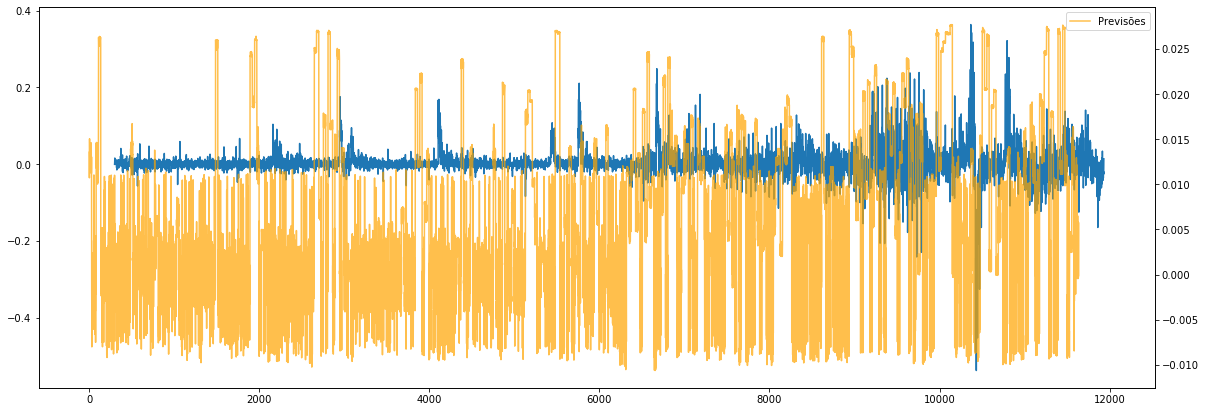

In [82]:
mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=1000, min_samples_leaf=128, max_features='auto')
mdl.fit(Xtr, ytr)
p = mdl.predict(Xval)
p_final = Xval['PRECO_MEDIO_REVENDA_ATUAL_0'] + p

print('ERRO', np.sqrt(mean_squared_log_error(yval_final, p_final)) * 100)

fig, ax = pylab.subplots(1,1, figsize=(20,7))
ax.plot(yval, label = 'Y')
axt = ax.twinx()
axt.plot(p, color = 'orange', alpha = 0.7, label='Previsões')
axt.legend()

## Ridge

ERRO 0.8224495164266573


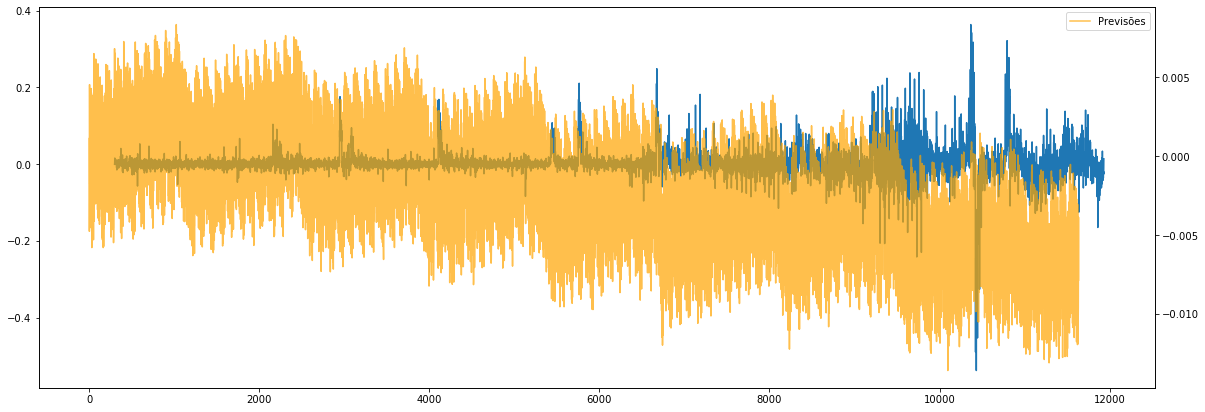

In [84]:
from sklearn.linear_model import Ridge
mdl = Ridge(random_state=0, alpha=10000.)
mdl.fit(Xtr, ytr)
p = mdl.predict(Xval)
p_final = Xval['PRECO_MEDIO_REVENDA_ATUAL_0'] + p

np.sqrt(mean_squared_log_error(yval_final, p_final)) * 100


print('ERRO', np.sqrt(mean_squared_log_error(yval_final, p_final)) * 100)
fig, ax = pylab.subplots(1,1, figsize=(20,7))
ax.plot(yval, label = 'Y')
axt = ax.twinx()
axt.plot(p, color = 'orange', alpha = 0.7, label='Previsões')
axt.legend()

# LightGBM

ERRO 0.8117345992150846


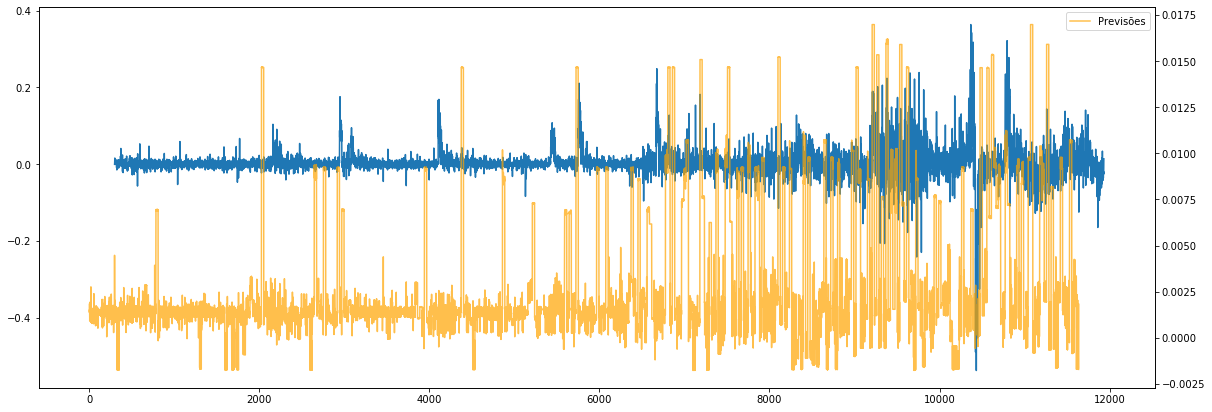

In [85]:
import lightgbm as lgb
mdl = lgb.LGBMRegressor(n_jobs=-1, random_state=0, n_estimators=100, learning_rate=0.001, num_leaves=2**6, subsample=0.9, subsample_freq=1,
                       colsample_bytree=1.)
mdl.fit(Xtr, ytr)
p = mdl.predict(Xval)
p_final = Xval['PRECO_MEDIO_REVENDA_ATUAL_0'] + p

print("ERRO", np.sqrt(mean_squared_log_error(yval_final, p_final)) * 100)

fig, ax = pylab.subplots(1,1, figsize=(20,7))
ax.plot(yval, label = 'Y')
axt = ax.twinx()
axt.plot(p, color = 'orange', alpha = 0.7, label='Previsões')
axt.legend()

# Sequential Forward Feature Selection


In [29]:
aceitas = []
valor_menor_erro= 10000

for step in range(20):
    var_menor_erro = None
    for var in Xtr.columns:
        if var in aceitas:
            continue
        #mdl = RandomForestRegressor(n_jobs=-1, random_state=0, n_estimators=500)
        mdl.fit(Xtr[aceitas+[var]], ytr)
        p = mdl.predict(Xval[aceitas+[var]])

        p_final = Xval['PRECO_MEDIO_REVENDA_ATUAL_0'] + p
        yval_final = Xval['PRECO_MEDIO_REVENDA_ATUAL_0'] + yval

        erro = np.sqrt(mean_squared_log_error(yval_final, p_final)) * 100

        #print("Variável: {} - Erro: {:.4f}\n".format(var, erro))

        if erro < valor_menor_erro:
            var_menor_erro = var
            valor_menor_erro = erro
    if var_menor_erro is None:
        break
    aceitas.append(var_menor_erro)
        
    print("Melhor Variável: {} - Erro: {:.4f}\n".format(var_menor_erro, valor_menor_erro))
    print(aceitas)
    print()
    

Melhor Variável: MINAS GERAIS_DPRECO - Erro: 0.8140

['MINAS GERAIS_DPRECO']

Melhor Variável: DIFF_PRECO_MEDIO_REVENDA_ATUAL_1 - Erro: 0.8127

['MINAS GERAIS_DPRECO', 'DIFF_PRECO_MEDIO_REVENDA_ATUAL_1']

Melhor Variável: RIO DE JANEIRO_DPRECO - Erro: 0.8112

['MINAS GERAIS_DPRECO', 'DIFF_PRECO_MEDIO_REVENDA_ATUAL_1', 'RIO DE JANEIRO_DPRECO']

Melhor Variável: MARANHAO_DPRECO - Erro: 0.8103

['MINAS GERAIS_DPRECO', 'DIFF_PRECO_MEDIO_REVENDA_ATUAL_1', 'RIO DE JANEIRO_DPRECO', 'MARANHAO_DPRECO']

Melhor Variável: AMAPA_DPRECO - Erro: 0.8100

['MINAS GERAIS_DPRECO', 'DIFF_PRECO_MEDIO_REVENDA_ATUAL_1', 'RIO DE JANEIRO_DPRECO', 'MARANHAO_DPRECO', 'AMAPA_DPRECO']

Melhor Variável: AMAZONAS_DPRECO - Erro: 0.8086

['MINAS GERAIS_DPRECO', 'DIFF_PRECO_MEDIO_REVENDA_ATUAL_1', 'RIO DE JANEIRO_DPRECO', 'MARANHAO_DPRECO', 'AMAPA_DPRECO', 'AMAZONAS_DPRECO']

Melhor Variável: DIFF_PRECO_MEDIO_REVENDA_ATUAL_3 - Erro: 0.8085

['MINAS GERAIS_DPRECO', 'DIFF_PRECO_MEDIO_REVENDA_ATUAL_1', 'RIO DE JANEIRO_DP

In [ ]:
['MINAS GERAIS_DPRECO', 'RIO DE JANEIRO_DPRECO', 'MARANHAO_DPRECO', 'AMAPA_DPRECO', 'AMAZONAS_DPRECO', 'PARANA_DPRECO', 'PARA_DPRECO',
'DIFF_PRECO_MEDIO_REVENDA_ATUAL_1', 'DIFF_PRECO_MEDIO_REVENDA_ATUAL_2', 'DIFF_PRECO_MEDIO_REVENDA_ATUAL_3', 'DIFF_PRECO_MEDIO_REVENDA_ATUAL_10', 
'TGTENC_ESTADO', 'ESTADO_DISTRITO FEDERAL', 'ESTADO_ACRE']

ERRO 0.8083749501228196


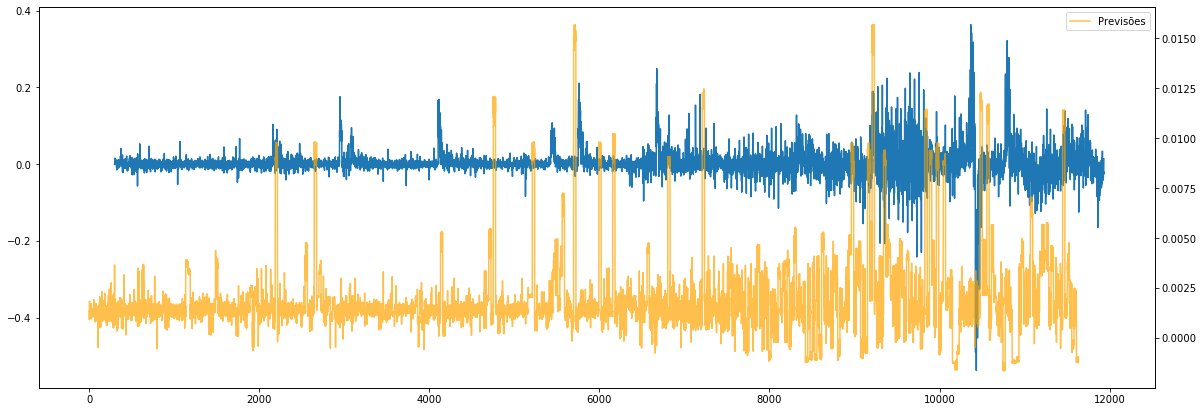

In [36]:
mdl.fit(Xtr[aceitas], ytr)
p = mdl.predict(Xval[aceitas])

p_final = Xval['PRECO_MEDIO_REVENDA_ATUAL_0'] + p
yval_final = Xval['PRECO_MEDIO_REVENDA_ATUAL_0'] + yval

print("ERRO", np.sqrt(mean_squared_log_error(yval_final, p_final)) * 100)

fig, ax = pylab.subplots(1,1, figsize=(20,7))
ax.plot(yval, label = 'Y')
axt = ax.twinx()
axt.plot(p, color = 'orange', alpha = 0.7, label='Previsões')
axt.legend()